**Hands-on 4 – Comparing TensorFlow/Keras and PyTorch**

_This hands-on was created by Thomas Grenier (TensorFlow) and Fabien Millioz (PyTorch), CREATIS, [deepimaging2019](https://deepimaging2019.sciencesconf.org/)_

thomas.grenier@creatis.insa-lyon.fr
fabien.millioz@creatis.insa-lyon.fr


# Introduction

**This file is dedicated to Pytorch. So be sure to have enabled Pytorch 0.4 (or higher version)**

Today, we will compare usages of two well-used deep learning frameworks for DNN: [TensorFlow](https://en.wikipedia.org/wiki/TensorFlow) (Google - 2015) and [PyTorch](https://en.wikipedia.org/wiki/PyTorch) (Facebook - 2016). Many others exist as [MXNet](https://en.wikipedia.org/wiki/MXNet), [Caffe](https://en.wikipedia.org/wiki/Caffe_(software), [Deeplearning4j](https://en.wikipedia.org/wiki/Deeplearning4j), ...

Most of these frameworks have low to high level APIs, meaning that you can develop the same network with detailed (low-level) functions to coarse (high-level) functions.

Pytorch presents two high-level features, tensor computation and neural networks, with a deep integration into Python.

> This practice will start using simple networks in Pytorch and progressively go deeper.


By the way, interesting ressources:
 - https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
 - https://pytorch.org/docs/stable/index.html
 
**About the data and exercices**

This hands-on is computer scientist-oriented more than application-oriented... 

And so, this practice focuses on a meaningless toy example inspired from the MNIST manuscript numbers classification challenge that is considered as the 'hello world' example for neural networks.

Here, we have to recognize wether a brain slice image is axial, sagittal or coronal and comes from MRI T1w, MRI T2w or CT modality. So, there are 9 classes as summarized here:

![Figure 1](./images_TP4/Figure1_SagittalAxialCoronal_small.png)

> Let's go!

# A - Setup

### A1 - First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to display the figures:

In [1]:
# install some packages (image reading/processing, graph/image display)
#!pip3 install pillow matplotlib pydot graphviz --user

# Common imports
import numpy as np
from PIL import Image
import os

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
    
def plot_image(image):
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    plt.imshow(image, aspect="equal", cmap="gray", interpolation="nearest")
    plt.axis("off")

### A2 - And of course we import PyTorch

In [2]:
import torch
torch.__version__

'0.4.1'

> _**if no error occurs, your working environment is ok and you can go to next part,
> else ... call an assistant for help!**_ 

## B - How does PyTorch work? THIS PART CAN BE SKIPPED
This section presents PyTorch and how it works.
This part is for users who would like to understand the low-level functionalities in PyTorch on which neural networks rely.

We start with a simple example where automatic differentiation is used, then we program a step-by-step classical gradient descent.

PyTorch works with tensors…

In [3]:
#Here is a PyTorch tensor 
a = torch.rand((2,2))
print(a)

tensor([[0.1930, 0.8929],
        [0.6046, 0.9226]])


… which are numpy arrays…

In [4]:
print(a.numpy())

[[0.19295597 0.8928736 ]
 [0.6045514  0.9225962 ]]


… with automatic differentiation!

We can calculate the gradients of the function $c(a) = (3a+2)^2$

In [5]:
a.requires_grad=True
print(a)
b = 3*(a+2)**2
print(b)
c = b.mean()
print(c)

tensor([[0.1930, 0.8929],
        [0.6046, 0.9226]], requires_grad=True)
tensor([[14.4272, 25.1062],
        [20.3511, 25.6247]], grad_fn=<MulBackward>)
tensor(21.3773, grad_fn=<MeanBackward1>)


Gradient of $c(a)$ is $\nabla c(a) = \frac{3 (a+2)}{2}$.

Here we evaluate it automatically from $c$.

In [6]:
c.backward()

print("PyTorch autograd:")
print(a.grad)
print("True gradient:")
print(3/2*(a+2))

PyTorch autograd:
tensor([[3.2894, 4.3393],
        [3.9068, 4.3839]])
True gradient:
tensor([[3.2894, 4.3393],
        [3.9068, 4.3839]], grad_fn=<MulBackward>)


Note that the gradients are cumulative:

In [7]:
b = 3*(a+2)**2
c = b.mean()
c.backward()
print(a.grad)

tensor([[6.5789, 8.6786],
        [7.8137, 8.7678]])


And therefore, it may be necessary some times to reset the gradient with:

In [8]:
a.grad.data.zero_()
print(a.grad)

tensor([[0., 0.],
        [0., 0.]])


This mechanism provides the necessary tools to train a neural network.

### An example of gradient descent:

The gradients $\frac{\partial L(y - h(x))}{\partial w}$ and $\frac{\partial L(y - h(x))}{\partial b}$ are computed with:
- $h(x) = \sigma(w. x + b)$
- $\sigma$ is the sigmoid activation function
- $L(y, \hat{y}) = (y - \hat{y})^2$ (quadratic error)
- $y = 0.2$
- $x = 1.5$
- $b = -2$
- $w = 3$

In [9]:
x = torch.tensor([1.5])                             #x = tf.constant(1.5)
y = torch.tensor([0.2])                             #y = tf.constant(0.2)
b = torch.tensor([-2.0], requires_grad=True)        #b = tf.Variable(-2.0, name="b")
w = torch.tensor([3.0], requires_grad=True)         #w = tf.Variable(3.0, name="w")

h = torch.sigmoid( w*x + b)                         #h = tf.math.sigmoid(w*x + b)
error = (y - h)**2                                  #error = (y - h)**2
error.backward()

print("h      = ", h.data)
print("grad b = ", b.grad.data)
print("grad w = ", w.grad.data)

h      =  tensor([0.9241])
grad b =  tensor([0.1015])
grad w =  tensor([0.1523])


We minimize $L(y, h(x))$ step-by-step.

Weights and bias are updated according to their gradients:

$w = w - \alpha . \frac{\partial L(y - h(x))}{\partial w}$

$b = b - \alpha . \frac{\partial L(y - h(x))}{\partial b}$

with $\alpha$ the learning rate.

In [10]:
x = torch.tensor([1.5])                             #x = tf.constant(1.5)
y = torch.tensor([0.2])                             #y = tf.constant(0.2)
b = torch.tensor([-2.0], requires_grad=True)        #b = tf.Variable(-2.0, name="b")
w = torch.tensor([3.0], requires_grad=True)         #w = tf.Variable(3.0, name="w")

alpha = 1                                           #alpha = tf.constant(1)
for i in range(20):
    h = torch.sigmoid(w * x + b)                    #h = tf.math.sigmoid(w*x + b)
    error = (y - h)**2                              #error = (y - h)**2
    error.backward()
    
    w.data = w.data - alpha * w.grad.data
    w.grad.data.zero_()  # must reset to 0 before next pass
    
    b.data = b.data - alpha * b.grad.data
    b.grad.data.zero_()  # must reset to 0 before next pass
    
    print('Epoch {} error={:.05f} h={:.05f} w={:.05f} b={:.05f}'.format(i+1, error.data[0], h.data[0], w.data[0], b.data[0]))

Epoch 1 error=0.52438 h=0.92414 w=2.84770 b=-2.10153
Epoch 2 error=0.48654 h=0.89753 w=2.65524 b=-2.22984
Epoch 3 error=0.42554 h=0.85233 w=2.40893 b=-2.39404
Epoch 4 error=0.32713 h=0.77195 w=2.10687 b=-2.59542
Epoch 5 error=0.19148 h=0.63758 w=1.80353 b=-2.79765
Epoch 6 error=0.07669 h=0.47693 w=1.59628 b=-2.93582
Epoch 7 error=0.02818 h=0.36786 w=1.47917 b=-3.01388
Epoch 8 error=0.01234 h=0.31107 w=1.40777 b=-3.06149
Epoch 9 error=0.00623 h=0.27892 w=1.36015 b=-3.09323
Epoch 10 error=0.00344 h=0.25865 w=1.32641 b=-3.11572
Epoch 11 error=0.00201 h=0.24488 w=1.30152 b=-3.13232
Epoch 12 error=0.00123 h=0.23504 w=1.28261 b=-3.14492
Epoch 13 error=0.00077 h=0.22776 w=1.26797 b=-3.15469
Epoch 14 error=0.00049 h=0.22223 w=1.25644 b=-3.16237
Epoch 15 error=0.00032 h=0.21794 w=1.24727 b=-3.16849
Epoch 16 error=0.00021 h=0.21457 w=1.23990 b=-3.17340
Epoch 17 error=0.00014 h=0.21189 w=1.23394 b=-3.17737
Epoch 18 error=0.00009 h=0.20975 w=1.22910 b=-3.18060
Epoch 19 error=0.00006 h=0.20801 w=1.

> **Question:** Observe the influence of $\alpha$ for values of 0.01, 0.1, 10 and 100, and try to adapt the number of epochs.

# C - Read the data

### C1 - Open files and convert to numpy / PyTorch 

We'll start by reading _png_ files stored in the data directory. 
Note that the filename of the _png_ image describes which view (Axial, Coronal, Sagital) and modality (T1w or T2w or CT) corresponds to the image.

These _png_ correspond to slices extracted from 3D volumes. In order to reduce the data variability (and simplify the slice extraction scripts), all MRI volumes, and respectively CT, have been registered on a reference image using [elastix](http://elastix.isi.uu.nl/). 

Thus, the origin, spacing, orientation and number of pixels per dimensions of all volumes are the same and therefore will not need to be taken into account systematically by the learning scripts (using SimpleITK, MedPy, nibabel...).

Then, slices were extracted and the window/level was adapted (using [ITK](https://itk.org/)).

Finally, they were resized to 64x64 (using [ImageMagick](https://www.imagemagick.org/)).

> **Before running the next cell**, you have to attach the dataset ```dlss_ho4_data``` using the tab on right.
>    1.  in Data filed, enter  ```dlss_ho4_data```   
>    2.  select it from the list
>    3.  click on "Attach dataset"  

The mount point should be ```/floyd/input/dlss_ho4_data```: the data will be accessed from this directory.

> The next cell will open all images and create `X_data` (containing the images) and `y_data` the corresponding labels.


In [11]:
input_path = '/floyd/input/dlss_ho4_data/'


original_height = 64
original_width  = 64

half_kernel_size = 0
desired_height = original_height - 2*half_kernel_size
desired_width = original_width - 2*half_kernel_size


med_view = {
        "T1-A":0,
        "T1-S":1,
        "T1-C":2,
        "T2-A":3,
        "T2-S":4,
        "T2-C":5,
        "CT-A":6,
        "CT-S":7,
        "CT-C":8}

rev_med_view = {
        0:"T1-A",
        1:"T1-S",
        2:"T1-C",
        3:"T2-A",
        4:"T2-S",
        5:"T2-C",
        6:"CT-A",
        7:"CT-S",
        8:"CT-C"}

# compute the number of files
nb_file = 0
for filename in os.listdir(input_path):
    if filename.endswith(".png"):
        nb_file += 1
print(" ** nb files : {}".format(nb_file))

X_data = np.zeros((nb_file, desired_height, desired_width), dtype=np.uint8)
y_data = np.zeros( nb_file, dtype=np.uint8)
im_index = 0
for filename in os.listdir(input_path):
    if filename.endswith(".png"):
        if (im_index % (nb_file // 20 )) == 0  :  print('-', end='', flush=True)
        im = Image.open(input_path+filename)
        im_np = np.array(im.getdata())
        im_np.shape = (original_height, original_width)
        X_data[im_index, :, :] = im_np[half_kernel_size:original_height-half_kernel_size,half_kernel_size:original_width-half_kernel_size]
        y_data[im_index] = med_view[ (filename[-8:-4]) ]
        im_index += 1

print("\n labels of the 30 first images : ", y_data[0:30])

 ** nb files : 21314
---------------------
 labels of the 30 first images :  [3 0 5 2 1 8 2 6 3 3 3 0 1 4 3 0 0 1 1 1 0 2 2 2 1 3 0 4 0 2]


We then shuffle the data:

In [12]:
#shuffle data and labels
rnd_data = np.random.permutation(len(X_data))
X_tmp = X_data
y_tmp = y_data
indx = 0
for indx_r in rnd_data:
    X_data[indx, :, :] = X_tmp[indx_r, :, :]
    y_data[indx]       = y_tmp[indx_r]
    indx += 1

print("\n labels of the 30 first images (shuffled): ", y_data[0:30])


 labels of the 30 first images (shuffled):  [4 5 3 1 2 5 0 1 2 1 2 2 3 3 2 4 2 1 5 5 5 8 3 8 4 2 4 4 4 1]


### C2 - Displaying the images

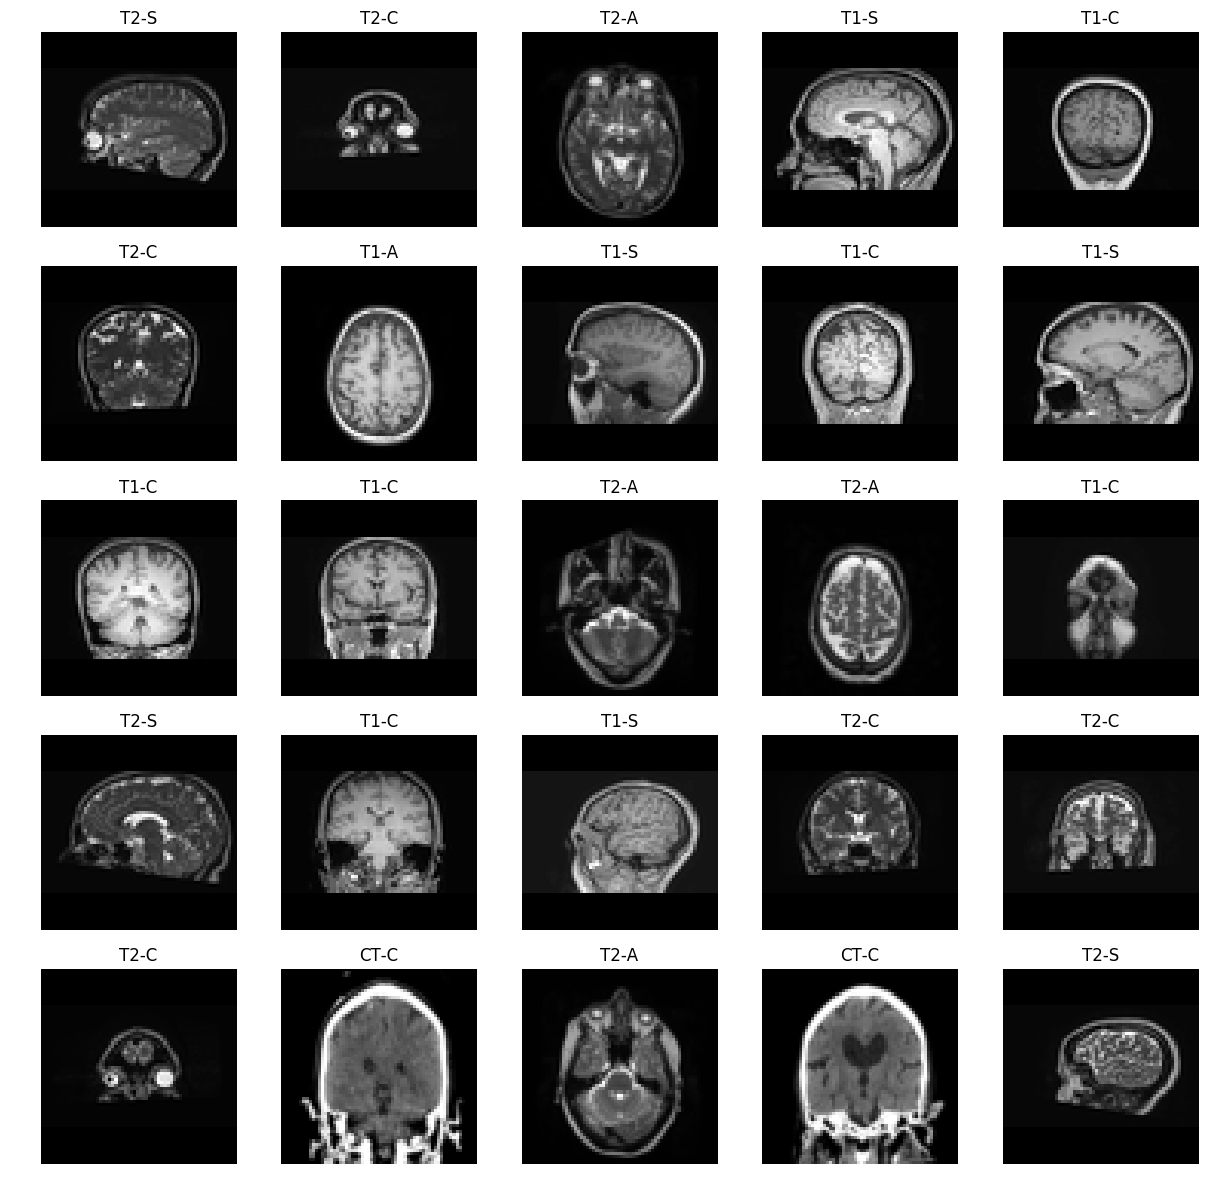

In [13]:
nb_x = 5
nb_y = 5
plt.figure(figsize=(15, 15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_data[i-1].reshape(desired_width, desired_height) )
    plt.title(rev_med_view[y_data[i-1]])

### C3 - Convert the data shape and type
Unfortunately, there are no clear rules to create train, valid and test sets.

The one presented here is useful and simple when you don't need to randomize your inputs in order to assess size effect nor training stability using k-fold cross-validations.

This solution also plays around with the `reshape` operator of numpy.

In [14]:
# is there a GPU available?
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# first: convert type to tensors
X_data = torch.from_numpy(X_data.astype(np.float32).reshape(-1, desired_width*desired_height) / 255.0)
y_data = torch.from_numpy(y_data.astype(np.int64))

# send it to the best device
X_data = X_data.to(device)
y_data = y_data.to(device)

# third: define training+valid sets vs test set
nb_train = 400                                                  # selects only 400 samples from 21 314
X_train, y_train = X_data[:nb_train], y_data[:nb_train]
X_test, y_test   = X_data[nb_train:], y_data[nb_train:]

# fourth: split training and valid sets
nb_valid = nb_train * 10 // 100
X_valid, X_train = X_train[:nb_valid], X_train[nb_valid:]
y_valid, y_train = y_train[:nb_valid], y_train[nb_valid:]

### C4 - Check the output data size and type
We recommend to check as often as needed the shape and type of data.

The first step that must be done is the data visualization.

Don't go further if you can't see what is inside array and tensor!

In [15]:
print(X_train.shape , y_train.shape)
print(X_valid.shape, y_valid.shape )
print(X_test.shape, y_test.shape)
print(X_train.dtype, y_train.dtype, X_train.device, y_train.device)

torch.Size([360, 4096]) torch.Size([360])
torch.Size([40, 4096]) torch.Size([40])
torch.Size([20914, 4096]) torch.Size([20914])
torch.float32 torch.int64 cuda:0 cuda:0


> _**All done, go to the network!**_

# D - Simple Neural network 
The simplest way to create, train and test a network is to use _Sequential container_ (Pytorch or Keras).

With a sequential container, you can quickly design a linear stack of layers and so, many kinds of models (LSTM, CNN, ...).

You can have a look at the PyTorch Documentation at [https://pytorch.org/docs/stable/nn.html#sequential](https://pytorch.org/docs/stable/nn.html#sequential)

### D1 - Here we create a simple Multilayer Perceptron (MLP) for multi-class softmax classification

In [16]:
#import torch.nn as nn  # usual import of the neural network module; not used in this notebook

image_size = desired_height * desired_width
nb_neurons = 16

model = torch.nn.Sequential(
            torch.nn.Linear(image_size, nb_neurons),  # first layer, fully-connected
            torch.nn.ReLU(),                          # activation function
            torch.nn.Linear(nb_neurons, 9),
            torch.nn.LogSoftmax(dim=1)
        )
model = model.to(device)

### D2 - Then we configure the parameters of the training step

In [40]:
losses = []      # initialization of the training loss
accuracies = []  # initialization of the training accuracy

nb_epochs = 10
learning_rate = 1e-4
loss = torch.nn.NLLLoss()  # negative log likelihood loss
my_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def evaluate(prediction, ground_truth):  # define the method to evaluate the model
    Y_pred = prediction.data.max(dim=1)[1] # [1] for the max position
    accuracy = Y_pred.eq(ground_truth).sum().cpu().numpy()/ground_truth.size()[0]
    return accuracy

### D3 - **Now let train the model**

In [41]:
for epoch in range(nb_epochs):
    prediction = model(X_train)
    l = loss(prediction, y_train)
    l.backward()
    my_optimizer.step()       # applies the gradient descent
    my_optimizer.zero_grad()  # clears gradients
    accuracy = evaluate(prediction, y_train)
      
    print("Epoch {}: error={:.05f} accuracy={:.05f}".format(epoch, l, accuracy))
    losses.append(l)
    accuracies.append(accuracy)


Epoch 0: error=1.30676 accuracy=0.71667
Epoch 1: error=1.30207 accuracy=0.71667
Epoch 2: error=1.29739 accuracy=0.71667
Epoch 3: error=1.29274 accuracy=0.71667
Epoch 4: error=1.28814 accuracy=0.71667
Epoch 5: error=1.28354 accuracy=0.71667
Epoch 6: error=1.27895 accuracy=0.71944
Epoch 7: error=1.27439 accuracy=0.71944
Epoch 8: error=1.26988 accuracy=0.71944
Epoch 9: error=1.26539 accuracy=0.71944


> **If you want to run more epochs, just run again the cell above!** and see how accuracy converges to 1 ;)

### D4 - Check the accuracy on the test set

In [42]:
prediction = model(X_test)
l = loss(prediction, y_test)
accuracy = evaluate(prediction, y_test)

print("loss={:.05f}, accuracy={:.05f}".format(l, accuracy))

loss=1.26922, accuracy=0.69709


> **Question 1**: It is not so bad! But try to increase the number of hidden neurons in the model (D1) to improve the test accuracy.

> **Question 2**: Ok, for now we use only 400 images. Increase their number and check that the test accuracy is improved.

> **Question 3**: For fun, add a Dropout layer to your model between the Linear layers.
[Documentation of Pytorch](https://pytorch.org/docs/stable/nn.html)

### D5 - Focus on one test prediction

Test and evaluation on a large data set is nice for assessment, but what about _a_ given result?

The following code performs a label prediction on the image $i$ in the test set:

In [52]:
i = 1
test_input = X_test[i].reshape(1,-1)   # reshape from shape [4096] to [1, 4096]
y_t = model(test_input)                # apply the model on the given input
print("Label probabilities : ", y_t)

Label probabilities :  tensor([[-2.7349, -1.7151, -1.5904, -3.2936, -1.1251, -2.4291, -4.0059, -3.0315,
         -3.3527]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


> **Complete the following line** which should print the true label from ```y_test``` and the one predicted from ```y_pred```:

In [53]:
print( "true label      : ", y_test[i] )
print( "predicted label : ", torch.argmax(y_t))    
print( "predicted label : ", y_t.data.max(dim=1)[1])    

true label      :  tensor(4, device='cuda:0')
predicted label :  tensor(4, device='cuda:0')
predicted label :  tensor([4], device='cuda:0')


### D6 - Displaying the image is **always** a good idea.

Text(0.5, 1.0, 'true: T2-S, predict: T2-S')

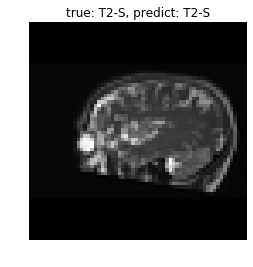

In [54]:
plot_image( X_test[i].reshape(desired_width, desired_height) )
plt.title("true: " + rev_med_view[int(y_test[i])] + ", predict: " + rev_med_view[int(torch.argmax(y_t))])

### D7 - See the model architecture

In [55]:
print(model)

Sequential(
  (0): Linear(in_features=4096, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=9, bias=True)
  (3): LogSoftmax()
)


### D8 - Save the model

In [56]:
torch.save(model, "my_simple_PyTorch_model.pth")

### D9 - Load the model

In [57]:
loaded_model = torch.load("my_simple_PyTorch_model.pth")
print(model)
prediction = loaded_model(X_test)
print("Accuracy on the test set : ", evaluate(prediction, y_test))

Sequential(
  (0): Linear(in_features=4096, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=9, bias=True)
  (3): LogSoftmax()
)
Accuracy on the test set :  0.6970928564597877


More details on saving and loading models: [https://pytorch.org/tutorials/beginner/saving_loading_models.html](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### D10 - Watch learning curves
During the training, we saved the loss and the accuracy at each iteration in the lists ```losses``` and ```accuracies```.

The following lines display the corresponding curves.

Text(0.5, 0, 'Iterations')

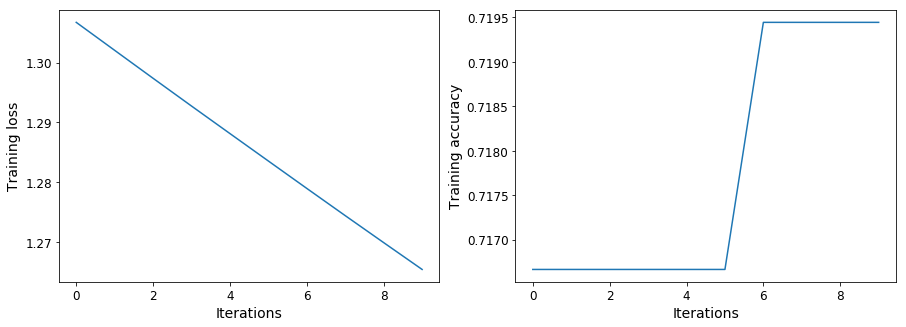

In [58]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.ylabel("Training loss")
plt.xlabel("Iterations")
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.ylabel("Training accuracy")
plt.xlabel("Iterations")

Modify the previous cell to add your own network.

Don't forget to reset the lists ```losses``` and ```accuracies```!

**Change the training parameters and try to see an overfitting effect.**

# E - Convolutional Neural Network

Now we will create a neural network using convolutional layers.

A more flexible way of defining a neural network is to define a custom class:

In [59]:
#import torch.nn.functional as F  # shortcut for activation functions

class My_Net(torch.nn.Module):
    def __init__(self):  # here, we define the network layers
        super(My_Net, self).__init__() # initialize from the superclass 
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.linear = torch.nn.Linear(16*16*16, 9)

    def forward(self, X):  # here, we define how the input is processed
        X = X.view(-1, 1, 64, 64)     # reshape as a (batch_size×1 layer×)64×64 image
        X = torch.nn.functional.relu(self.conv1(X))     # first layer with Relu activation
        X = torch.nn.functional.relu(self.conv2(X))
        X = self.maxpool(X)
        X = self.linear(X.view(-1,16*16*16))
        return torch.nn.functional.log_softmax(X, dim=1)

Note that in this case, a Sequential is enough but this method is for instance mandatory to implement skip connections.

Here, we check how the input size changes through each layer:

In [60]:
cnn_model = My_Net().to(device)

X = X_train[:10,:].view(-1, 1, 64, 64)
print(X.shape)
X = torch.nn.functional.relu(cnn_model.conv1(X))
print(X.shape)
X = torch.nn.functional.relu(cnn_model.conv2(X))
print(X.shape)
X = cnn_model.maxpool(X)
print(X.shape)
X = cnn_model.linear(X.view(-1, 16*16*16))
print(X.shape)
X = torch.nn.functional.log_softmax(X, dim=1)
print(X.shape)

torch.Size([10, 1, 64, 64])
torch.Size([10, 8, 64, 64])
torch.Size([10, 16, 32, 32])
torch.Size([10, 16, 16, 16])
torch.Size([10, 9])
torch.Size([10, 9])


Before starting the training, we will look at two different good practices.

### E1 - Dealing with batch sizes
In this example, we have few images of small size. Consequently, all the data fit in memory, and an epoch runs on a single batch.
Usually, the training data have to be loaded in minibatches to run a full epoch.
Pytorch provides a nice way to deal with it.

In [61]:
from torch.utils.data import TensorDataset  # a way to combine data and ground truth
from torch.utils.data import DataLoader

my_batch_size = 100
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=my_batch_size)

for x_train_batch, y_train_batch in train_dl:
    print(x_train_batch.shape, y_train.shape)
    # it is thus easy to iterate in this for loop

torch.Size([100, 4096]) torch.Size([360])
torch.Size([100, 4096]) torch.Size([360])
torch.Size([100, 4096]) torch.Size([360])
torch.Size([60, 4096]) torch.Size([360])


Shuffling the minibatches is a good idea, to avoid learning on the same sequences at each epoch.

To do so, we just have to add the option ```shuffle=True``` in the DataLoader.

### E2 -  Adding a validation process
A validation step is a useful way to avoid overfitting.

At each epoch, the neural network is evaluated on the validation set, but not trained on it.

If the validation loss starts to grow, it means that the network is overfitting the training set, and that it is time to stop the training.

In [63]:
#Here is the skeleton of the epoch loop using validation 
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=my_batch_size, shuffle=True)  # so the batches will change at each epoch
valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(train_ds, batch_size=my_batch_size)

for epoch in range(nb_epochs):
    model.train()  # train mode. Usefull for certain types of layers such that Dropout.
    train_loss = 0
#    for x_train_batch, y_train_batch in train_dl:
#        prediction = model(X_train)
#        l = loss(prediction, y_train)
#        l.backward()
#        train_loss += l
#        my_optimizer.step()
#        my_optimizer.zero_grad()
    
    model.eval()  # evaluation mode. Dropout won't do anything
    with torch.no_grad():  # we don't compute gradients in evaluation, and thus reduce memory requirements
        valid_loss = 0
#        for x_valid_batch, y_valid_batch in valid_dl:
#            valid_loss += loss(model(x_valid_batch), y_valid_batch)

### E3 - Let's train!
We use the validation dataset to check overfitting.

In [64]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

nb_epoch = 10
my_batch_size = 180
learning_rate = 1e-5
loss = torch.nn.NLLLoss()  # negative log likelihood loss

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=my_batch_size, shuffle=True)
valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=my_batch_size)

cnn_model = My_Net().to(device)
my_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

for epoch in range(nb_epoch):
    cnn_model.train()  # train mode. Usefull for certain types of layers such that DropOut.
    train_loss = 0
    nb_train_batch = 0
    for x_train_batch, y_train_batch in train_dl:
        nb_train_batch += 1
        prediction = cnn_model(x_train_batch)
        l = loss(prediction, y_train_batch)
        l.backward()
        my_optimizer.step()
        my_optimizer.zero_grad()
        train_loss += l
        train_accuracy = evaluate(prediction, y_train_batch)
    
    cnn_model.eval()  # evaluation mode. DropOut won't do anything
    with torch.no_grad():  # we don't compute gradients in evaluation, and thus reduce memory requirements
        valid_loss = 0
        nb_valid_batch = 0
        for x_valid_batch, y_valid_batch in valid_dl:
            nb_valid_batch += 1
            prediction = cnn_model(x_valid_batch)
            valid_loss += loss(prediction, y_valid_batch)
            valid_accuracy = evaluate(prediction, y_valid_batch)
            
    train_losses.append(train_loss/nb_train_batch)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss/nb_valid_batch)
    valid_accuracies.append(valid_accuracy)

print("The training is finished!")

The training is finished!


Don't hesitate to change the network parameters, as well as the training parameters!

You can check the network efficiency and potential overfitting with the code below:

In [ ]:
plt.figure(figsize=(15,5), dpi=100)
plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="train")
plt.plot(valid_accuracies, label="valid")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()

You can compare the fully-connected network with the CNN.

Below is a comparison in terms of trainable parameters for both models.

In [ ]:
cnn_model = My_Net()
print("Number of parameters in the CNN             : ", sum(p.numel() for p in cnn_model.parameters()))

image_size = desired_height * desired_width
nb_neurons = 16

model = torch.nn.Sequential(
            torch.nn.Linear(image_size, nb_neurons),  # first layer, fully-connected
            torch.nn.ReLU(),                          # activation function
            torch.nn.Linear(nb_neurons, 9),
            torch.nn.LogSoftmax(dim=1)
        )
print("Number of parameters in the fully connected : ", sum(p.numel() for p in model.parameters()))